In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import lasagne
 

# Convolutional Neural networks 101

Convolution neural networks are one of the most succesfull types of neural networks for image recognition and an integral part of reigniting the interest in neural networks. 

In this lab we'll experiment with inserting 2D-convolution layers in the fully connected neural networks introduced in LAB1. We'll furhter experiment with stacking of convolution layers, max pooling and strided convolutions which are all important techniques in current convolution neural network architectures. Lastly we'll try to visualize the learned convolution filters and try to understand what kind of features they learn to recognize.


If you are unfamilar with the the convolution operation  https://github.com/vdumoulin/conv_arithmetic have a nice visualization of different convolution variants. For a more indept tutorial please see http://cs231n.github.io/convolutional-networks/ or http://neuralnetworksanddeeplearning.com/chap6.html. Lastly if you are ambitious and want implement a convolution neural network from scratch please see an exercise for our Deep Learning summer school last year https://github.com/DTU-deeplearning/day2-Conv

In [ ]:
#LOAD the mnist data. To speed up training we'll only work on a subset of the data.
#Note that we reshape the data from (nsamples, num_features)= (nsamples, nchannels*rows*cols)  -> (nsamples, nchannels, rows, cols)
# in order to retain the spatial arrangements of the pixels
data = np.load('mnist.npz')
num_classes = 10
nchannels,rows,cols = 1,28,28
x_train = data['X_train'][:10000].astype('float32')
x_train = x_train.reshape((-1,nchannels,rows,cols))
targets_train = data['y_train'][:10000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
x_valid = x_valid.reshape((-1,nchannels,rows,cols))
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
x_test = x_test.reshape((-1,nchannels,rows,cols))
targets_test = data['y_test'][:500].astype('int32')

In [ ]:
#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

In [ ]:
#Define a simple feed forward neural network

from lasagne.nonlinearities import leaky_rectify, softmax, tanh, elu
from lasagne.layers import InputLayer, DenseLayer, Conv2DLayer, batch_norm, DropoutLayer, MaxPool2DLayer

#defined the model
num_class = 10
num_features = x_train.shape[1]

l_in = InputLayer(shape=(None,nchannels,rows,cols)) #note that we use a 4D input since we need to retain the spatial arrangement of the pixels when working with convolutions.
#l_conv = Conv2DLayer(l_in,num_filters=16,filter_size=5)
l_hid = DenseLayer(l_in, num_units=100, nonlinearity=elu) #remember to connect the new conv-layer here
l_out = DenseLayer(l_hid, num_units=num_class, nonlinearity=softmax)

In [ ]:
#Setting up the graph in theano
sym_x = T.tensor4('sym_x') # a symbolic variable, this is now a 4-D tensor.
sym_t = T.ivector('sym_t') # a symbolic variable taking on the value of the target batch.

# Get network output
train_out = lasagne.layers.get_output(l_out, sym_x, deterministic=False)
eval_out = lasagne.layers.get_output(l_out, sym_x, deterministic=True)


# Get list of all trainable parameters in the network.
all_params = lasagne.layers.get_all_params(l_out, trainable=True)

cost = T.nnet.categorical_crossentropy(train_out+1e-8, sym_t).mean()
# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(cost, all_params)


# Set the update function for parameters 
# you might wan't to experiment with more advanded update schemes like rmsprob, adadelta etc.
updates = lasagne.updates.adam(all_grads, all_params, learning_rate=0.001)


f_eval = theano.function([sym_x],
                     eval_out, on_unused_input='warn')

f_train = theano.function([sym_x, sym_t],
                          [cost],
                          updates=updates, on_unused_input='warn')

In [ ]:
#Test the forward pass
x = np.random.normal(0,1, (45, 1,28,28)).astype('float32') #dummy data

model = lasagne.layers.get_output(l_out, sym_x)
out = model.eval({sym_x:x}) #this could also include mask etc if used
print("l_out", out.shape)

In [ ]:
#Training Loop
from confusionmatrix import ConfusionMatrix
batch_size = 100
num_epochs = 20
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []
try:
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        cur_loss = 0
        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            target_batch = targets_train[idx]    
            batch_loss = f_train(x_batch,target_batch) #this will do the complete backprob pass
            cur_loss += batch_loss[0]
        loss += [cur_loss/batch_size]

        confusion_valid = ConfusionMatrix(num_classes)
        confusion_train = ConfusionMatrix(num_classes)

        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            targets_batch = targets_train[idx]
            net_out = f_eval(x_batch)   
            preds = np.argmax(net_out, axis=-1) 
            confusion_train.batch_add(targets_batch, preds)

        confusion_valid = ConfusionMatrix(num_classes)
        for i in range(num_batches_valid):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_valid[idx]
            targets_batch = targets_valid[idx]
            net_out = f_eval(x_batch)   
            preds = np.argmax(net_out, axis=-1) 

            confusion_valid.batch_add(targets_batch, preds)

        train_acc_cur = confusion_train.accuracy()
        valid_acc_cur = confusion_valid.accuracy()

        train_acc += [train_acc_cur]
        valid_acc += [valid_acc_cur]
        print "Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
        % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur)
except KeyboardInterrupt:
    pass
    

#get test set score
confusion_test = ConfusionMatrix(num_classes)
net_out = f_eval(x_test)    
preds = np.argmax(net_out, axis=-1) 
confusion_test.batch_add(targets_test, preds)
print "\nTest set Acc:  %f" %(confusion_test.accuracy())


epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

# Assignments 1

 1) Note the performance of the standard feedforward neural network. Add a 2D convolution layer before the dense hidden layer and confirm that it increases the generalization performance of the network (try num_filters=16 and filter_size=5 as a starting point). 
 
 2) Can the performance be increases even further by stacking more convolution layers ?
 
 3) Maxpooling is a technique for decreasing the spatial resolution of an image while retaining the important features. Effectively this gives a local translational invariance and reduces the computation by a factor of four. In the classification algorithm which is usually desirable. Try to either: 
 
     a) add a maxpool layer(add arguement pool_size=2)  after the convolution layer or
     b) set add stride=2 to the arguments of the convolution layer. 
  Verify that this decreases spatial dimension of the image. (print l_conv.output_shape or print   l_maxpool.output_shape). Does this increase the performance of the network (you may need to stack multiple layers or increase the number of filters to increase performance) ?
  


# Visualization of filters
Convolution filters can be interpreted as spatial feature detectors picking up different image features such as edges, corners etc. Below we provide code for visualization of the filters. The best results are obtained with fairly large filters of size 9 and either 16 or 36 filters. 

In [ ]:
np_W = l_conv.W.get_value() #get the filter values from the conv layer
print np_W.shape, "i.e. the shape is num_filters, num_channels, filter_size, filter_size"
num_filters,num_channels,filter_size,_= np_W.shape
n = int(num_filters**0.5)

np_W_res = np_W.reshape(n,n,num_channels,filter_size,filter_size)
fig, ax = plt.subplots(n,n)
print "learned filter values"
for i in range(n):
    for j in range(n):
        ax[i,j].imshow(np_W_res[i,j,0], cmap='gray',interpolation='none')
        ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
        ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())


idx = 1
plt.figure()
plt.imshow(x_train[idx,0],cmap='gray',interpolation='none')
plt.title('Inut Image')
plt.show()

#visalize the filters convolved with an input image
from scipy.signal import convolve2d
np_W_res = np_W.reshape(n,n,num_channels,filter_size,filter_size)
fig, ax = plt.subplots(n,n,figsize=(9,9))
print "Response from input image convolved with the filters"
for i in range(n):
    for j in range(n):
        ax[i,j].imshow(convolve2d(x_train[1,0],np_W_res[i,j,0],mode='same'), cmap='gray',interpolation='none')
        ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
        ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())



# Assignment 2

The visualized filters will likely look most like noise due to the small amount of training data.

 1) Try to use 10000 traning examples instead and visualise the filters again
 
 2) Dropout is a very usefull technique for preventing overfitting. Try to add a DropoutLayer after the convolution layer and hidden layer. This should increase both performance and the "visual appeal" of the filters
 
 3) Batch normalization is a recent innovation for improving generalization performance. Try to insert batch normalization layers into the network to improve performance. 
 
 


#Even more fun with convolutions
More or less copied from https://github.com/Lasagne/Recipes/blob/master/examples/spatial_transformer_network.ipynb

Using a [spatial transformer layer](http://lasagne.readthedocs.io/en/latest/modules/layers/special.html#lasagne.layers.TransformerLayer) [1] a convolutional network can be trained to only focus on part of an image. 

[1] Jaderberg, Max, et al. "Spatial Transformer Networks." arXiv preprint arXiv:1506.02025 (2015).

### Get the data

In [ ]:
!wget -N https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz

In [ ]:
idx = 0
canvas = np.zeros((DIM*10, 10*DIM))
for i in range(10):
    for j in range(10):
        canvas[i*DIM:(i+1)*DIM, j*DIM:(j+1)*DIM] = data['X_train'][idx].reshape((DIM, DIM))
        idx += 1
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.title('Cluttered handwritten digits')
plt.axis('off')

plt.show()

In the data the each mnist digit (20x20 pixels) has been placed randomly in a 60x60 canvas. To make the task harder each canvas has then been cluttered with small pieces of digits. In this task it is helpfull for a network if it can focus only on the digit and ignore the rest.

The ``TransformerLayer`` lets us do this. The transformer layer learns an affine transformation which lets the network zoom, rotate and skew. If you are interested you should read the paper, but the main idea is that you can let a small convolutional network determine the the parameters of the affine transformation. You then apply the affine transformation to the input data. Usually this also involves downsampling which forces the model to zoom in on the relevant parts of the data. After the affine transformation we can use a larger conv net to do the classification. 
This is possible because you can backprop through a an affine transformation if you use bilinear interpolation.

In [1]:
%matplotlib inline
import os
import matplotlib
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import lasagne
import theano
import theano.tensor as T
conv = lasagne.layers.Conv2DLayer
pool = lasagne.layers.MaxPool2DLayer
NUM_EPOCHS = 500
BATCH_SIZE = 256
LEARNING_RATE = 0.001
DIM = 60
NUM_CLASSES = 10
mnist_cluttered = "mnist_cluttered_60x60_6distortions.npz"



Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
def load_data():
    data = np.load(mnist_cluttered)
    X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
    X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
    X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)

    # reshape for convolutions
    X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
    X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
    X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))
    
    print "Train samples:", X_train.shape
    print "Validation samples:", X_valid.shape
    print "Test samples:", X_test.shape

    return dict(
        X_train=lasagne.utils.floatX(X_train),
        y_train=y_train.astype('int32'),
        X_valid=lasagne.utils.floatX(X_valid),
        y_valid=y_valid.astype('int32'),
        X_test=lasagne.utils.floatX(X_test),
        y_test=y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=10,)
data = load_data()

Train samples: (50000, 1, 60, 60)
Validation samples: (10000, 1, 60, 60)
Test samples: (10000, 1, 60, 60)


## Building the model

We use a model where the localization network is a two layer convolution network which operates directly on the image input. The output from the localization network is a 6 dimensional vector specifying the parameters in the affine transformation.

We set up the transformer layer to initially do the identity transform, similarly to [1]. If the output from the localization networks is [t1, t2, t3, t4, t5, t6] then t1 and t5 determines zoom, t2 and t4 determines skewness, and t3 and t6 move the center position. By setting the initial values of the bias vector to 

```
|1, 0, 0|
|0, 1, 0|
```
and the final W of the localization network to all zeros we ensure that in the beginning of training the network works as a pooling layer. 

The output of the localization layer feeds into the transformer layer which applies the transformation to the image input. In our setup the transformer layer downsamples the input by a factor 3.

Finally a 2 layer convolution layer and 2 fully connected layers calculates the output probabilities.


### The model
```
Input -> localization_network -> TransformerLayer -> output_network -> predictions
   |                                |
   >--------------------------------^
```




In [ ]:
def build_model(input_width, input_height, output_dim,
                batch_size=BATCH_SIZE):
    ini = lasagne.init.HeUniform()
    l_in = lasagne.layers.InputLayer(shape=(None, 1, input_width, input_height),)

    # Localization network
    b = np.zeros((2, 3), dtype=theano.config.floatX)
    b[0, 0] = 1
    b[1, 1] = 1
    b = b.flatten()
    loc_l1 = pool(l_in, pool_size=(2, 2))
    loc_l2 = conv(
        loc_l1, num_filters=8, filter_size=(5, 5), W=ini)
    loc_l3 = pool(loc_l2, pool_size=(2, 2))
    loc_l4 = conv(loc_l3, num_filters=8, filter_size=(5, 5), W=ini)
    loc_l5 = lasagne.layers.DenseLayer(
        loc_l4, num_units=50, W=lasagne.init.HeUniform('relu'))
    loc_out = lasagne.layers.DenseLayer(
        loc_l5, num_units=6, b=b, W=lasagne.init.Constant(0.0), 
        nonlinearity=lasagne.nonlinearities.identity)
    
    # Transformer network
    l_trans1 = lasagne.layers.TransformerLayer(l_in, loc_out, downsample_factor=3.0)
    print "Transformer network output shape: ", l_trans1.output_shape
    
    # Classification network
    class_l1 = conv(
        l_trans1,
        num_filters=16,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l2 = pool(class_l1, pool_size=(2, 2))
    class_l3 = conv(
        class_l2,
        num_filters=16,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l4 = pool(class_l3, pool_size=(2, 2))
    class_l5 = lasagne.layers.DenseLayer(
        class_l4,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )

    l_out = lasagne.layers.DenseLayer(
        class_l5,
        num_units=output_dim,
        nonlinearity=lasagne.nonlinearities.softmax,
        W=ini,
    )

    return l_out, l_trans1

model, l_transform = build_model(DIM, DIM, NUM_CLASSES)
model_params = lasagne.layers.get_all_params(model, trainable=True)


In [ ]:
X = T.tensor4()
y = T.ivector()

# training output
output_train = lasagne.layers.get_output(model, X, deterministic=False)

# evaluation output. Also includes output of transform for plotting
output_eval, transform_eval = lasagne.layers.get_output([model, l_transform], X, deterministic=True)

sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

train = theano.function([X, y], [cost, output_train], updates=updates)
eval = theano.function([X], [output_eval, transform_eval])

### Training the model
Unfortunately NVIDIA has yet to squeeze a TitanX into a labtop and training convnets on CPU is painfully slow. After 10 epochs you should see that model starts to zoom in on the digits. 

In [ ]:
def train_epoch(X, y):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        if i % 10 == 0:
            print i,
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        cost_batch, output_train = train(X_batch, y_batch)
        costs += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)
    print ""
    return np.mean(costs), correct / float(num_samples)


def eval_epoch(X, y):
    output_eval, transform_eval = eval(X)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return acc, transform_eval

In [ ]:
valid_accs, train_accs, test_accs = [], [], []
try:
    for n in range(NUM_EPOCHS):
        train_cost, train_acc = train_epoch(data['X_train'], data['y_train'])
        valid_acc, valid_trainsform = eval_epoch(data['X_valid'], data['y_valid'])
        test_acc, test_transform = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
        test_accs += [test_acc]
        train_accs += [train_acc]

        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.7
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))

        print "Epoch {0}: Train cost {1}, Train acc {2}, val acc {3}, test acc {4}".format(
                n, train_cost, train_acc, valid_acc, test_acc)
except KeyboardInterrupt:
    pass

### Plot errors and zoom

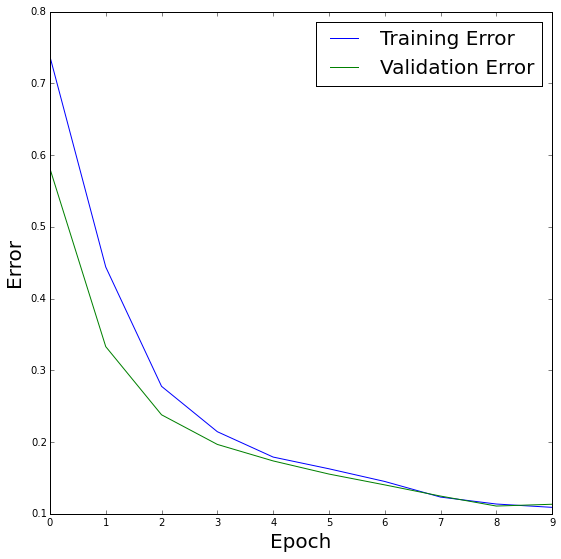

In [35]:
plt.figure(figsize=(9,9))
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(valid_accs), label='Validation Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.show()

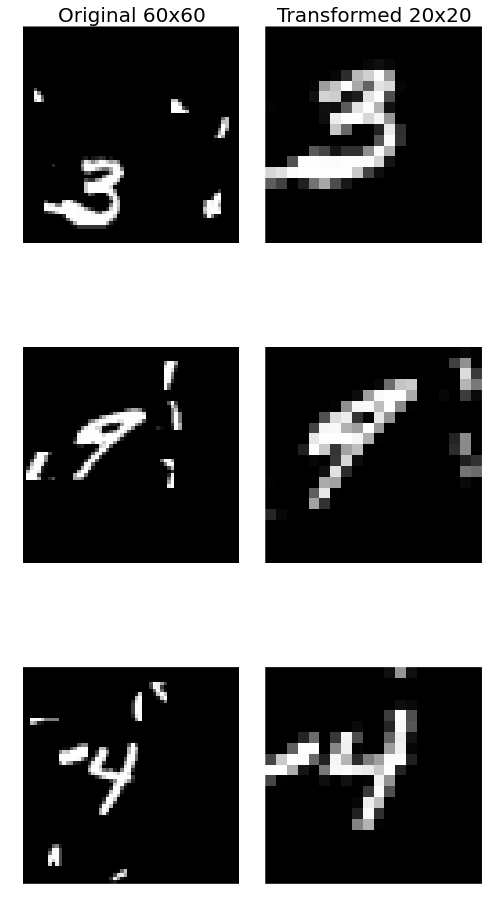

In [36]:
plt.figure(figsize=(7,14))
for i in range(3):
    plt.subplot(321+i*2)
    plt.imshow(data['X_test'][i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(322+i*2)
    plt.imshow(test_transform[i].reshape(DIM//3, DIM//3), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')
    
    
plt.tight_layout()

# A few pointers for image classification
If you want do image classification using a pretrained model is often a good choice, especially if you have limited amounts of labeled data. 

An often used pretrained network is the VGG16 and VGG19. Lasagne has pretrained models in the [modelzoo](https://github.com/Lasagne/Recipes/tree/master/modelzoo). Torch7 and Tensorflow have similar pretrained models that you can find with google. 

Currently the best performing image networks is [ResNet](https://arxiv.org/pdf/1512.03385v1.pdf). Torch7 has an interesting blog post about Residual nets. http://torch.ch/blog/2016/02/04/resnets.html


